In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
import matplotlib.pyplot as plt

RANDOM_SEEDS = 8965, 197009

RuntimeError: To use MKL 2018 with Theano you MUST set "MKL_THREADING_LAYER=GNU" in your environement.

---

# Question 3

The accompanying CSV files ‘pitchclassificationtrain.csv’ and ‘pitchclassificationtest.csv’ contain information from nearly 20,000 pitches from five different pitchers over three years. There are 13 columns:

- `pitchid`: a unique identifier for each pitch.
- `pitcherid`: identity of the pitcher (1-5). The identities are the same in both datasets.  		Pitcher 3 in the training set is the same pitcher as Pitcher 3 in the test set.
- `yearid`: year in which the pitch occurred (1-3).
- `throws`: handedness of the pitcher, where 1 = right-handed and 2 = left-handed
- `height`: height in inches of the pitcher.
- `initspeed`: initial speed of the pitch as it leaves the pitcher's hand, reported in MPH
- `breakx`: horizontal distance in inches between where a pitch crossed the plate and where a hypothetical spinless pitch would have, where negative is inside to a right-handed hitter.
- `breakz`: vertical distance in inches between where a pitch crossed the plate and where a hypothetical spinless pitch would have, where negative is closer to the ground.
- `initposx`: horizontal position of the release point of the pitch. The position is measured in feet from the center of the rubber when the pitch is released, where negative is towards the third-base side of the rubber.
- `initposz`: vertical position of the release point of the pitch.  The position is measured in feet above the ground.
- `extension`: distance in feet in front of the pitching rubber from which the pitcher releases the ball.
- `spinrate`: how fast the ball is spinning as it leaves the pitcher's hand, reported in RPM
- `type`: type of pitch that was thrown (will only appear in the training dataset).

Your goal is to give the most likely pitch type for all of the pitches in the test dataset using information from the training dataset. Note that the pitchers in the datasets do not correspond with any specific real pitchers but are meant to be representative of real data. Please include the following with your final submission:

1.	CSV with two columns: the pitchid and the corresponding predicted pitch type
2.	write-up of your method and results, including any tables or figures that help communicate your findings
3.	all code used to solve the problem


This is a multi-class classification problem. One approach is to use a parametric statistical model, and express the pitch class as a categorical outcome. However, this requires the explicit specification of the combinations of variables thought to be predictive of pitch type *a priori*. A more flexible approach, and an effective one when plenty of data are available (as we have here), is to use an ensemble machine learning algorithm. A key advantage of such methods is that higher-order interactions among variables that may be powerful predictors can be discovered automatically, without pre-specification. 

An effective ensemble method for classification is **gradient boosting**. Boosting combines a set of "weak" learners (ones that, individually, perform only slightly better than chance) to a yield a system with very high predictive performance. The idea is that by sequentially applying very fast, simple models, we can get a total model error which is better than any of the individual pieces. Each successive fit to a new weak learner yields and estimate of residual error, which is used to weight the remaining observations such that the next learner emphasizes the classification of observations that have not yet been correctly classified. The process is stagewise, meaning that existing trees are left unchanged as the model is enlarged. Only the fitted value for each observation is re-estimated at each step to reflect the contribution of the newly added tree. The final model is a linear combination of many trees (usually hundreds to thousands) that can be thought of as a classification/regression model where each term itself is a tree.

On average, boosting outperforms competing algorithms like random forests or support vector machines, but requires less data than deep neural networks, which are often applied to large classification tasks.

[XGBoost](https://arxiv.org/abs/1603.02754) is an open-source, high-performance implementation of gradient boosting methods for decision trees. It features natively-parallel tree construction, out-of-core computation, and cache optimization, and is readily deployable on clusters. It typically offers better speed and performance relative to `scikit-learn` and other comparable libraries.

Import data from csv files.

In [4]:
from pybaseball import statcast

pitch_data = statcast(start_dt='2017-04-01', end_dt='2017-04-30')

This is a large query, it may take a moment to complete
Completed sub-query from 2017-04-01 to 2017-04-05
Completed sub-query from 2017-04-06 to 2017-04-06
Completed sub-query from 2017-04-07 to 2017-04-12
Completed sub-query from 2017-04-13 to 2017-04-18
Completed sub-query from 2017-04-19 to 2017-04-24
Completed sub-query from 2017-04-25 to 2017-04-30


In [5]:
pitch_data.shape

(108785, 79)

In [12]:
pitch_data.pitch_type.value_counts()

FF    25503
SL    11794
FT     9566
CH     7474
CU     5422
SI     5004
FC     3846
KC     1734
FS     1239
KN      371
FO       38
EP       18
PO        8
SC        4
AB        2
UN        1
Name: pitch_type, dtype: int64

In [7]:
pitch_type = pitch_data.pop('pitch_type')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                    pitch_data, pitch_type, test_size=0.33, random_state=42)

Extract columns to be used for prediction. Pitcher and year are probably not predictive, so I am leaving them out.

In [11]:
prediction_cols = ['p_throws', 'release_spin_rate', 'effective_speed', 'release_extension',
                   'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az']

Relabel pitch types using the `scikit-learn` label encoder (XGboost requires sequential labels).

In [37]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder().fit(y_train)
y_train_encoded = encoder.transform(y_train)

XGBoost runs faster using its own binary data structures:

In [38]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train[prediction_cols], label=y_train_encoded)
dtest = xgb.DMatrix(X_test[prediction_cols])

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We can specify the hyperparameters of the model, to use as a starting point for the analysis.

In [39]:
xgb_params = {
    'max_depth': 12,  
    'eta': 0.2, 
    'nthread': 4,                # Use 4 cores for multiprocessing
    'num_class': 6,              # pitch types
    'objective': 'multi:softmax' # use softmax multi-class classification
}

In [40]:
boosted_classifier = xgb.train(xgb_params, dtrain, num_boost_round=30)

Using arbitrarily-chosen hyperparemeters, the model achieves nearly perfect accuracy on the training set.

In [41]:
from sklearn.metrics import accuracy_score

predictions = boosted_classifier.predict(dtrain)
accuracy_score(y_train_encoded, predictions)

0.99889478337754201

However, this model may be overfit to the training dataset, so I am going to use 5-fold cross-validation to select hyperparameters that result in the best fit.

In [57]:
param_grid = [(max_depth, min_child_weight, eta) for max_depth in (6, 8, 10, 12) 
                                                 for min_child_weight in (7, 9, 11, 13)
                                                 for eta in (0.15, 0.2, 0.25)]

In [58]:
min_merror = np.inf
best_params = None

for max_depth, min_child_weight, eta in param_grid:
    print("CV with max_depth={}, min_child_weight={}, eta={}".format(
                             max_depth,
                             min_child_weight,
                             eta))

    # Update our parameters
    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        xgb_params,
        dtrain,
        num_boost_round=50,
        nfold=5,
        metrics={'merror'}, 
        early_stopping_rounds=3
    )

    # Update best score
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].idxmin()
    print("\tmerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth, min_child_weight, eta)

print("Best params: {}, {}, {}, merror: {}".format(best_params[0], best_params[1], best_params[2], min_merror))

CV with max_depth=6, min_child_weight=7, eta=0.15
	merror 0.051363400000000003 for 35 rounds
CV with max_depth=6, min_child_weight=7, eta=0.2
	merror 0.051878999999999995 for 18 rounds
CV with max_depth=6, min_child_weight=7, eta=0.25
	merror 0.051289600000000005 for 21 rounds
CV with max_depth=6, min_child_weight=9, eta=0.15
	merror 0.0517316 for 28 rounds
CV with max_depth=6, min_child_weight=9, eta=0.2
	merror 0.051289600000000005 for 19 rounds
CV with max_depth=6, min_child_weight=9, eta=0.25
	merror 0.052026399999999993 for 17 rounds
CV with max_depth=6, min_child_weight=11, eta=0.15
	merror 0.0535002 for 25 rounds
CV with max_depth=6, min_child_weight=11, eta=0.2
	merror 0.052395199999999996 for 17 rounds
CV with max_depth=6, min_child_weight=11, eta=0.25
	merror 0.05128959999999999 for 19 rounds
CV with max_depth=6, min_child_weight=13, eta=0.15
	merror 0.052026800000000005 for 31 rounds
CV with max_depth=6, min_child_weight=13, eta=0.2
	merror 0.05099479999999999 for 28 rounds


I can select the best parameters from the cross-validation procedure to use to predict on the test data (I could do a more refined search of the hyperparameter space, but the multiclass errors appear to be broadly similar across the range of values that I used, so I will stick with these).

In [61]:
xgb_params = {
    'max_depth': 10,  
    'eta': 0.2, 
    'min_child_weight': 9,       # minimum sum of instance weight needed in a child 
    'nthread': 4,                # use 4 cores for multiprocessing
    'num_class': 6,              # pitch types
    'objective': 'multi:softmax' # use softmax multi-class classification
}

In [62]:
boosted_classifier = xgb.train(xgb_params, dtrain, num_boost_round=30)

The accuracy score for the training data is nominally lower than the original model, but not much; moreover this model should perform better in out-of-sample prediction.

In [63]:
from sklearn.metrics import accuracy_score

predictions = boosted_classifier.predict(dtrain)
accuracy_score(y_train_encoded, predictions)

0.97782198644267615

Below is a plot of feature importances, using the F-score. This quantifies how many times a particular variable is used as a splitting variable across all the trees. This ranking makes intiutive sense, with movement and velocity being the most relevant factors.

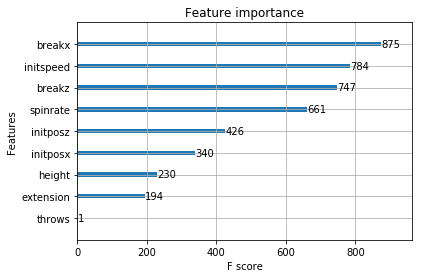

In [64]:
xgb.plot_importance(boosted_classifier)

Generate predictions on the test set using fitted classifier.

In [65]:
test_predictions = boosted_classifier.predict(dtest)

In [66]:
test_predictions

array([ 5.,  1.,  5., ...,  1.,  3.,  1.], dtype=float32)

Back-transform label encoding, and export to `predicted_pitches_fonnesbeck.csv`.

In [67]:
predicted_pitches = pd.Series(encoder.inverse_transform(test_predictions.astype(int)), index=X_test.index)
predicted_pitches.name = 'pitch_type'
predicted_pitches.index.name = 'pitchid'
predicted_pitches.to_csv('predicted_pitches_fonnesbeck.csv', header=True)